In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import apply_cats, proc_df
from fastai.column_data import *
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import dill as pickle
from IPython.display import display

pd.options.display.max_columns = None
import numpy as np
np.set_printoptions(threshold=50, edgeitems=20)
data_path=Path('data/')
PATH = data_path
SK_ID_CURR = "SK_ID_CURR"

# TODOS:

Try to fix overfitting - by remove extra information

In [3]:
cred_card_bal = pickle.load(open('data/credit_card_balance','rb'))
pos_cash_bal = pickle.load(open('data/POS_CASH_balance','rb'))
prev = pickle.load(open('data/previous_application','rb'))
bureau_bal = pickle.load(open('data/bureau_balance','rb'))
install = pickle.load(open('data/installments_payments','rb'))
bureau = pickle.load(open('data/bureau','rb'))
application_train = pickle.load(open('data/application_train','rb'))
application_test = pickle.load(open('data/application_test','rb'))

In [4]:
merged_df = pickle.load(open('data/merged_df.pickle','rb'))

In [5]:
len(merged_df.columns)

213

In [6]:
prev.sample(10)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
1487215,2425890,398311,Revolving loans,2250.000,45000.0,45000.0,NaN,45000.0,WEDNESDAY,11,Y,1,NaN,NaN,NaN,XAP,Approved,-153,XNA,XAP,Unaccompanied,Refreshed,XNA,Cards,walk-in,Country-wide,21,Connectivity,0.0,XNA,Card Street,365243.0,365243.0,365243.0,365243.0,365243.0,0.0
1495704,1557257,231833,Cash loans,10079.460,90000.0,95940.0,NaN,90000.0,MONDAY,10,Y,1,NaN,NaN,NaN,XNA,Approved,-362,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-332.0,-2.0,-152.0,-146.0,1.0
657835,1556724,181498,Consumer loans,3684.060,32436.0,32436.0,0.0,32436.0,SATURDAY,11,Y,1,0.000000,NaN,NaN,XAP,Approved,-91,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,15,Connectivity,10.0,low_normal,POS mobile without interest,365243.0,-52.0,218.0,365243.0,365243.0,0.0
1147223,2744343,274152,Cash loans,NaN,0.0,0.0,NaN,NaN,TUESDAY,10,Y,1,NaN,NaN,NaN,XNA,Refused,-231,XNA,SCOFR,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
723393,1896159,171069,Revolving loans,2250.000,0.0,45000.0,NaN,NaN,SATURDAY,10,Y,1,NaN,NaN,NaN,XAP,Approved,-479,XNA,XAP,NaN,Repeater,XNA,Cards,x-sell,Credit and cash offices,-1,XNA,0.0,XNA,Card X-Sell,365243.0,365243.0,365243.0,365243.0,365243.0,0.0
298911,2566694,297975,Cash loans,22119.705,202500.0,215865.0,NaN,202500.0,SATURDAY,8,Y,1,NaN,NaN,NaN,XNA,Approved,-556,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-526.0,-196.0,-346.0,-333.0,1.0
759171,2187168,367161,Cash loans,22425.975,225000.0,239850.0,NaN,225000.0,FRIDAY,13,Y,1,NaN,NaN,NaN,XNA,Refused,-161,Cash through the bank,HC,Unaccompanied,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,low_normal,Cash X-Sell: low,NaN,NaN,NaN,NaN,NaN,NaN
1098826,1037502,412153,Consumer loans,15464.970,154665.0,139198.5,15466.5,154665.0,SUNDAY,7,Y,1,0.108909,NaN,NaN,XAP,Approved,-2630,XNA,XAP,Family,New,Consumer Electronics,POS,XNA,Stone,800,Consumer electronics,10.0,low_normal,POS household without interest,365243.0,-2599.0,-2329.0,-2359.0,-2350.0,0.0
743314,1690653,212992,Consumer loans,5327.820,25911.0,25911.0,0.0,25911.0,SATURDAY,12,Y,1,0.000000,NaN,NaN,XAP,Approved,-24,XNA,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,58,Connectivity,6.0,high,POS mobile with interest,365243.0,365243.0,167.0,365243.0,365243.0,0.0
980605,1886871,277173,Consumer loans,8919.180,98193.6,88370.1,9823.5,98193.6,MONDAY,20,Y,1,0.108955,0.19333,0.852537,XAP,Approved,-205,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,30,Connectivity,12.0,middle,POS mobile with interest,365243.0,-168.0,162.0,365243.0,365243.0,0.0


In [99]:
list(merged_df.columns)

['AMT_ANNUITY',
 'AMT_CREDIT',
 'AMT_GOODS_PRICE',
 'AMT_INCOME_TOTAL',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'APARTMENTS_AVG',
 'APARTMENTS_MEDI',
 'APARTMENTS_MODE',
 'BASEMENTAREA_AVG',
 'BASEMENTAREA_MEDI',
 'BASEMENTAREA_MODE',
 'CNT_CHILDREN',
 'CNT_FAM_MEMBERS',
 'CODE_GENDER',
 'COMMONAREA_AVG',
 'COMMONAREA_MEDI',
 'COMMONAREA_MODE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_REGISTRATION',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'ELEVATORS_AVG',
 'ELEVATORS_MEDI',
 'ELEVATORS_MODE',
 'EMERGENCYSTATE_MODE',
 'ENTRANCES_AVG',
 'ENTRANCES_MEDI',
 'ENTRANCES_MODE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'FLAG_CONT_MOBILE',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT

In [7]:
def most_recent_sk_id(curr_sk_id):
    columns = prev[prev["SK_ID_CURR"] == curr_sk_id]
    most_recent_loan = columns[columns["DAYS_DECISION"] == max(columns["DAYS_DECISION"])]
    recent_prev_sk_id = list(most_recent_loan["SK_ID_PREV"])[0]
    return recent_prev_sk_id

In [9]:
largest_idx = prev.groupby(["SK_ID_CURR"], sort=False)['DAYS_DECISION'].idxmax()

In [ ]:
def get_nth_columns(prev_df):
    largest_idx = prev_df.groupby(["SK_ID_CURR"], sort=False)['DAYS_DECISION'].idxmax()
    return prev_df[prev_df.index.isin(largest_idx.values)]

In [67]:
largest_idx = prev.groupby(["SK_ID_CURR"], sort=False)['DAYS_DECISION'].nlargest(2, keep="first")

In [114]:
loan_count_dist = prev.groupby(["SK_ID_CURR"], sort=False).size()

## Add loan count 

In [106]:
merged_df["LOAN_CNT"] = loan_count_dist

In [107]:
len(merged_df)

356255

In [115]:
loan_count_dist = loan_count_dist.values

In [123]:
less_than_10 = list(filter(lambda x: x < 10, loan_count_dist))
less_than_20 = list(filter(lambda x: 10 < x and x < 20, loan_count_dist))
less_than_30 = list(filter(lambda x: 20 < x and x < 30, loan_count_dist))
less_than_100 = list(filter(lambda x: 30 < x and x < 100, loan_count_dist))

(array([6854., 5214., 4099., 3206.,    0., 2385., 1876., 1518., 1129.,  929.]),
 array([11. , 11.8, 12.6, 13.4, 14.2, 15. , 15.8, 16.6, 17.4, 18.2, 19. ]),
 <a list of 10 Patch objects>)

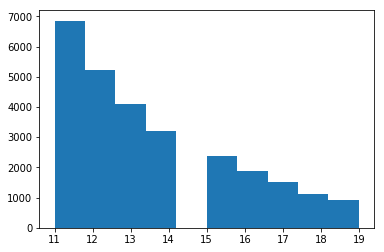

In [120]:
matplotlib.pyplot.hist(less_than_20)

(array([60458., 52737., 45966., 38159.,     0., 30886., 24588., 19216., 15085., 11627.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <a list of 10 Patch objects>)

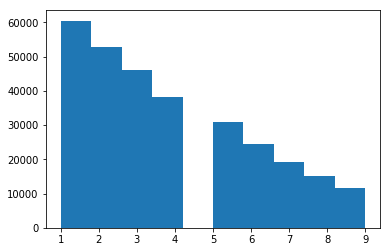

In [121]:
matplotlib.pyplot.hist(less_than_10)

(array([581., 462., 351., 320.,   0., 242., 198., 169., 134., 127.]),
 array([21. , 21.8, 22.6, 23.4, 24.2, 25. , 25.8, 26.6, 27.4, 28.2, 29. ]),
 <a list of 10 Patch objects>)

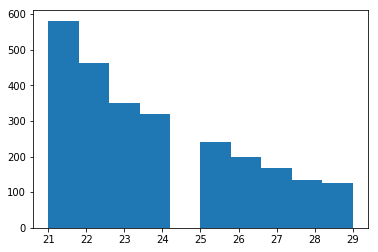

In [122]:
matplotlib.pyplot.hist(less_than_30)

(array([255.,  98.,  54.,  11.,  10.,   8.,  10.,   4.,   2.,   2.]),
 array([31. , 35.6, 40.2, 44.8, 49.4, 54. , 58.6, 63.2, 67.8, 72.4, 77. ]),
 <a list of 10 Patch objects>)

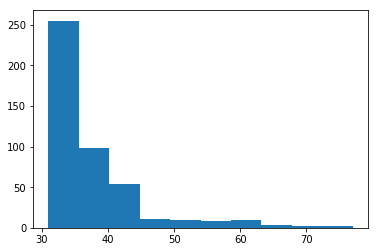

In [96]:
matplotlib.pyplot.hist(less_than_100)

In [127]:
def get_most_recent(prev_df):
    largest_idx = prev_df.groupby(["SK_ID_CURR"], sort=False)['DAYS_DECISION'].idxmax()
    return prev_df[prev_df.index.isin(largest_idx.values)]

In [128]:
most_recent = get_most_recent(prev)

In [129]:
joined_df = pd.merge(merged_df, most_recent, how='left', on=['SK_ID_CURR'], suffixes=["", "_add_1"])

In [130]:
joined_df[['DAYS_ID_PUBLISH', 'DAYS_BIRTH', 'DAYS_EMPLOYED']] = joined_df.loc[:, ['DAYS_ID_PUBLISH', 'DAYS_BIRTH', 'DAYS_EMPLOYED']].replace([365243], value=0)

In [131]:
train_df = joined_df.loc[joined_df[SK_ID_CURR].isin(application_train[SK_ID_CURR])]
test_df = joined_df.loc[joined_df[SK_ID_CURR].isin(application_test[SK_ID_CURR])]

In [132]:
assert(len(train_df) == len(application_train))

In [133]:
assert(len(test_df) == len(application_test))

In [134]:
len(train_df.columns)

250

In [135]:
samp_size = len(train_df)

In [136]:
train_ratio  = 0.75
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(train_df)))

In [137]:
val_idx[:10]

[230633,
 230634,
 230635,
 230636,
 230637,
 230638,
 230639,
 230640,
 230641,
 230642]

In [138]:
column_type_map = joined_df.columns.to_series().groupby(joined_df.dtypes).groups

In [139]:
dtype_int64, dtype_float64, dtype_o = column_type_map.keys()

In [140]:
column_type_map[dtype_int64]

Index(['CNT_CHILDREN', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH',
       'FLAG_CONT_MOBILE', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
       'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
       'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_2',
       'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_EMAIL',
       'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_PHONE', 'FLAG_WORK_PHONE',
       'HOUR_APPR_PROCESS_START', 'LIVE_CITY_NOT_WORK_CITY',
       'LIVE_REGION_NOT_WORK_REGION', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'SK_ID_CURR'],
      dtype='object')

In [141]:
column_type_map[dtype_o]

Index(['CODE_GENDER', 'EMERGENCYSTATE_MODE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'NAME_CONTRACT_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE',
       'ORGANIZATION_TYPE', 'WALLSMATERIAL_MODE', 'WEEKDAY_APPR_PROCESS_START',
       'NAME_CONTRACT_TYPE_BAVG', 'WEEKDAY_APPR_PROCESS_START_BAVG',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON',
       'NAME_TYPE_SUITE_BAVG', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY',
       'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE',
       'NAME_SELLER_INDUSTRY', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
       'NAME_CONTRACT_STATUS_CCAVG', 'STATUS', 'NAME_CONTRACT_STATUS_CAVG',
       'NAME_CONTRACT_TYPE_add_1', 'WEEKDAY_APPR_PROCESS_START_add_1',
       'FLAG_LAST_APPL_PER_CONTRACT_add_1', 'NAME_CASH_LOAN_PURPOSE_a

In [142]:
cat_vars  = list(set(column_type_map[dtype_int64])) + list(set(column_type_map[dtype_o]))

In [143]:
days = []
for var in cat_vars:
    if "DAYS" in var:
        days.append(var)

In [144]:
days

['DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'DAYS_BIRTH']

In [145]:
not_cat = ["SK_ID_CURR"] + days

In [146]:
not_cat

['SK_ID_CURR', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'DAYS_BIRTH']

In [147]:
cat_vars = list(set(cat_vars) - set(not_cat))

In [148]:
cat_vars = list(set(cat_vars) - set(days))

In [149]:
contin_vars = list(set(column_type_map[dtype_float64])) + not_cat

In [150]:
rm_list = ['SK_ID_PREV', 'SK_ID_PREV', 'SK_ID_PREV_add_1']

def rm(content, remove):
    return list(set(content) - set(remove))

contin_vars = rm(contin_vars, rm_list)
cat_vars = rm(cat_vars, rm_list)

In [151]:
not_cat

['SK_ID_CURR', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'DAYS_BIRTH']

In [152]:
contin_vars

['FLOORSMIN_MEDI',
 'FLOORSMIN_MODE',
 'DAYS_LAST_DUE_add_1',
 'FLOORSMIN_AVG',
 'YEARS_BUILD_AVG',
 'AMT_CREDIT_MAX_OVERDUE',
 'COMMONAREA_MODE',
 'SK_DPD_CAVG',
 'AMT_DRAWINGS_OTHER_CURRENT',
 'LIVINGAREA_MEDI',
 'CNT_DRAWINGS_CURRENT',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'FLOORSMAX_AVG',
 'NONLIVINGAREA_MEDI',
 'SK_DPD_DEF_CAVG',
 'TARGET',
 'NFLAG_INSURED_ON_APPROVAL_add_1',
 'LOAN_CNT',
 'AMT_GOODS_PRICE_add_1',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'DAYS_CREDIT_UPDATE',
 'CNT_INSTALMENT',
 'DAYS_FIRST_DRAWING_add_1',
 'DAYS_ID_PUBLISH',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'CNT_DRAWINGS_ATM_CURRENT',
 'CNT_DRAWINGS_OTHER_CURRENT',
 'BASEMENTAREA_MODE',
 'LIVINGAREA_MODE',
 'CNT_PAYMENT_add_1',
 'NONLIVINGAPARTMENTS_MEDI',
 'DAYS_ENDDATE_FACT',
 'ENTRANCES_MODE',
 'AMT_RECEIVABLE_PRINCIPAL',
 'SK_ID_CURR_CNT_BUREAU',
 'DAYS_DECISION_add_1',
 'SK_ID_PREV_CCAVG',
 'AMT_CREDIT',
 'CREDIT_DAY_OVERDUE',
 'RATE_INTEREST_PRIMARY_add_1',
 'SK_ID_BUREAU',
 'BASEMENTAREA_AVG',
 'YEARS_BUILD_MEDI',
 'AMT_INCO

In [153]:
for v in cat_vars:
    train_df[v] = train_df[v].astype('category')
    test_df[v] = test_df[v].astype('category')

/home/cheeseblubber/anaconda3/envs/fastai-latest/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/cheeseblubber/anaconda3/envs/fastai-latest/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [154]:
for v in contin_vars:
    train_df[v] = train_df[v].fillna(0).astype('float32')
    test_df[v] = test_df[v].fillna(0).astype('float32')

/home/cheeseblubber/anaconda3/envs/fastai-latest/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/cheeseblubber/anaconda3/envs/fastai-latest/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [155]:
cat_sz = [(c, len(train_df[c].cat.categories)+1) for c in cat_vars]

In [156]:
apply_cats(test_df, train_df)

/home/cheeseblubber/workspace/competition/home-default-credit/fastai/structured.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[n] = pd.Categorical(c, categories=trn[n].cat.categories, ordered=True)


In [157]:
cat_sz

[('FONDKAPREMONT_MODE', 5),
 ('REG_CITY_NOT_WORK_CITY', 3),
 ('NAME_PORTFOLIO_add_1', 6),
 ('NAME_SELLER_INDUSTRY_add_1', 12),
 ('FLAG_DOCUMENT_10', 3),
 ('OCCUPATION_TYPE', 19),
 ('NAME_PAYMENT_TYPE_add_1', 5),
 ('NAME_CONTRACT_STATUS', 5),
 ('NAME_PRODUCT_TYPE', 4),
 ('LIVE_REGION_NOT_WORK_REGION', 3),
 ('NAME_CONTRACT_STATUS_CCAVG', 5),
 ('PRODUCT_COMBINATION_add_1', 18),
 ('NAME_YIELD_GROUP', 6),
 ('FLAG_DOCUMENT_15', 3),
 ('FLAG_DOCUMENT_11', 3),
 ('FLAG_DOCUMENT_14', 3),
 ('FLAG_MOBIL', 3),
 ('FLAG_DOCUMENT_3', 3),
 ('NAME_PORTFOLIO', 6),
 ('FLAG_DOCUMENT_16', 3),
 ('REGION_RATING_CLIENT', 4),
 ('FLAG_LAST_APPL_PER_CONTRACT_add_1', 3),
 ('NAME_CONTRACT_STATUS_add_1', 5),
 ('FLAG_DOCUMENT_9', 3),
 ('FLAG_DOCUMENT_13', 3),
 ('FLAG_DOCUMENT_4', 3),
 ('FLAG_PHONE', 3),
 ('FLAG_DOCUMENT_2', 3),
 ('CHANNEL_TYPE', 9),
 ('FLAG_DOCUMENT_6', 3),
 ('REG_REGION_NOT_LIVE_REGION', 3),
 ('WALLSMATERIAL_MODE', 8),
 ('FLAG_EMAIL', 3),
 ('STATUS', 9),
 ('FLAG_DOCUMENT_18', 3),
 ('FLAG_EMP_PHONE', 

In [158]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [159]:
proc_train_df, y, _, mapper = proc_df(train_df, y_fld="TARGET", skip_flds=rm_list, do_scale=True)

/home/cheeseblubber/anaconda3/envs/fastai-latest/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [174]:
proc_test_df, _, nas, mapper = proc_df(test_df, do_scale=True, mapper=mapper)

/home/cheeseblubber/anaconda3/envs/fastai-latest/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [161]:
bs = 1000

In [162]:
y[:10]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [163]:
len(proc_test_df.columns)

252

In [196]:
list(set(proc_test_df.columns) - set(proc_train_df.columns))

['SK_ID_PREV_na',
 'TARGET',
 'SK_ID_PREV_add_1',
 'SK_ID_PREV',
 'SK_ID_PREV_add_1_na']

In [197]:
proc_test_df.drop(columns=['SK_ID_PREV_na',
 'TARGET',
 'SK_ID_PREV_add_1',
 'SK_ID_PREV',
 'SK_ID_PREV_add_1_na'], inplace=True)

In [198]:
proc_train_df.to_pickle("data/train_df1")
proc_test_df.to_pickle("data/test_df1")

In [199]:
test_df["TARGET"]

307511    0.0
307512    0.0
307513    0.0
307514    0.0
307515    0.0
307516    0.0
307517    0.0
307518    0.0
307519    0.0
307520    0.0
307521    0.0
307522    0.0
307523    0.0
307524    0.0
307525    0.0
307526    0.0
307527    0.0
307528    0.0
307529    0.0
307530    0.0
307531    0.0
307532    0.0
307533    0.0
307534    0.0
307535    0.0
307536    0.0
307537    0.0
307538    0.0
307539    0.0
307540    0.0
         ... 
356225    0.0
356226    0.0
356227    0.0
356228    0.0
356229    0.0
356230    0.0
356231    0.0
356232    0.0
356233    0.0
356234    0.0
356235    0.0
356236    0.0
356237    0.0
356238    0.0
356239    0.0
356240    0.0
356241    0.0
356242    0.0
356243    0.0
356244    0.0
356245    0.0
356246    0.0
356247    0.0
356248    0.0
356249    0.0
356250    0.0
356251    0.0
356252    0.0
356253    0.0
356254    0.0
Name: TARGET, Length: 48744, dtype: float32

In [200]:
"TARGET" in list(proc_train_df.columns)

False

In [201]:
list(set(proc_test_df.columns) - set(proc_train_df.columns))

[]

In [202]:
len(proc_test_df.columns)

247

In [203]:
# proc_test_df.drop(columns=["SK_ID_PREV", "SK_ID_CURR"], inplace=True)

KeyError: "labels ['SK_ID_PREV'] not contained in axis"

In [208]:
md = ColumnarModelData.from_data_frame(
    PATH, val_idx, proc_train_df, y.astype(np.int32), 
    cat_flds=cat_vars, bs=bs, is_reg=False, test_df=proc_test_df,
    is_multi=False
)

In [219]:
m = md.get_learner(emb_szs, len(proc_train_df.columns)-len(cat_vars), 0.1, 2, [100,40], drops=[0.25, 0.20])

In [220]:
m.lr_find()

epoch      trn_loss   val_loss                               
    0      0.966636   0.28061   


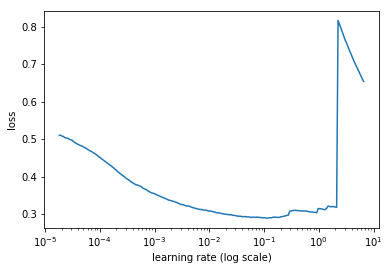

In [221]:
m.sched.plot()

In [222]:
lr = 1e-2

In [223]:
m.fit(lr, 1, cycle_len=2)

epoch      trn_loss   val_loss                               
    0      0.263003   0.246755  
    1      0.257008   0.246169                               


[array([0.24617])]

In [224]:
m.fit(lr, 2, cycle_len=2)

epoch      trn_loss   val_loss                               
    0      0.252524   0.245571  
    1      0.24824    0.245056                               
    2      0.25348    0.246266                               
    3      0.248009   0.24446                                


[array([0.24446])]

In [225]:
m.fit(lr/2, 5, wds=1e-7, cycle_len=3, best_save_name="best_home_default1")

epoch      trn_loss   val_loss                               
    0      0.25331    0.24502   
    1      0.247246   0.244089                               
    2      0.246186   0.244269                               
    3      0.247141   0.244732                               
    4      0.246      0.243968                               
    5      0.240818   0.243921                               
    6      0.24441    0.245242                               
    7      0.243346   0.244593                               
    8      0.241501   0.244598                               
    9      0.244114   0.246471                               
    10     0.243088   0.245198                               
    11     0.235364   0.245793                               
    12     0.242272   0.246356                               
    13     0.238743   0.246312                               
    14     0.234779   0.246698                               


[array([0.2467])]

In [226]:
m.load(name="best_home_default1")

In [227]:
m.fit(lr/20, 2, cycle_len=2, wds=1e-7, best_save_name="best_home_default2")

epoch      trn_loss   val_loss                               
    0      0.239981   0.244037  
    1      0.241336   0.244055                               
    2      0.240314   0.244281                               
    3      0.241573   0.244267                               


[array([0.24427])]

In [228]:
m.load(name="best_home_default2")

In [229]:
m.fit(lr/100, 2, cycle_len=2, wds=1e-7, best_save_name="best_home_default3")

epoch      trn_loss   val_loss                               
    0      0.240781   0.244055  
    1      0.243797   0.244058                               
    2      0.240715   0.244108                               
    3      0.240419   0.244108                               


[array([0.24411])]

In [230]:
m.load(name="best_home_default3")

In [191]:
m.fit(lr/200, 2, cycle_len=2, wds=1e-7, best_save_name="best_home_default3")

epoch      trn_loss   val_loss                               
    0      0.240971   0.243845  
    1      0.24114    0.243841                               
    2      0.24201    0.243893                               
    3      0.239349   0.243892                               


[array([0.24389])]

In [231]:
pred_test=m.predict(True)

In [232]:
pred_test = np.exp(pred_test)

In [233]:
pred_test[:,0]

array([0.95233, 0.84603, 0.95668, 0.93582, 0.85727, 0.96387, 0.99033, 0.93875, 0.99291, 0.91884, 0.97441,
       0.94762, 0.90235, 0.9617 , 0.94503, 0.90325, 0.94984, 0.98107, 0.90896, 0.94906, ..., 0.91477,
       0.94455, 0.96792, 0.97143, 0.96396, 0.92955, 0.94011, 0.99746, 0.91922, 0.96943, 0.92687, 0.93189,
       0.973  , 0.87605, 0.95676, 0.98473, 0.92664, 0.97337, 0.9484 , 0.78212], dtype=float32)

(array([    1.,     1.,     7.,    52.,   189.,  1019.,  1119.,  2522., 12032., 31802.]),
 array([0.22523, 0.30271, 0.38018, 0.45766, 0.53514, 0.61262, 0.69009, 0.76757, 0.84505, 0.92252, 1.     ]),
 <a list of 10 Patch objects>)

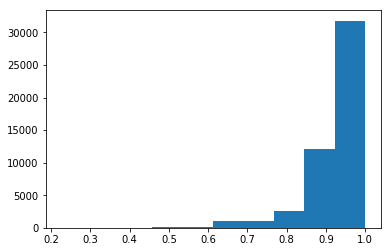

In [234]:
matplotlib.pyplot.hist(pred_test[:,0])

In [235]:
application_test['TARGET']=pred_test[:,1]

In [240]:
csv_fn=f'{PATH}/tmp/sub8.csv'

In [241]:
application_test['SK_ID_CURR'] = application_test['SK_ID_CURR'].astype(int)

In [242]:
application_test[['SK_ID_CURR','TARGET']].to_csv(csv_fn, index=False)

In [243]:
FileLink(csv_fn)

/home/cheeseblubber/workspace/competition/home-default-credit/data/tmp/sub8.csv

# More data = more overfitting??